[16:21:11] INFO - === Loading datasets for index 0 ===
[16:21:11] INFO - Loading True density: /scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/0.hdf5
[16:21:11] INFO - Loading prediction: /home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251021_163947/icase-ch1/0.hdf5
[16:21:11] INFO - Loading prediction: /home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251022_164527/icase-ch2/0.hdf5
[16:21:11] INFO - Loading prediction: /home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251014_210016/0.hdf5
[16:21:12] INFO - Loading Alex baseline: /scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/predictions/test_0_final_mode0_lr_min1e-07_max1e-05_200epochs_rho_240712_a100_cmb_f2.5.npy
[16:21:12] INFO - Detected overdensity (δ). Applied δ→ρ correction (+1).
[16:21:12] INFO - All datasets successfully loaded.
[16:21:12] INFO - Generating 5-panel visualization map...


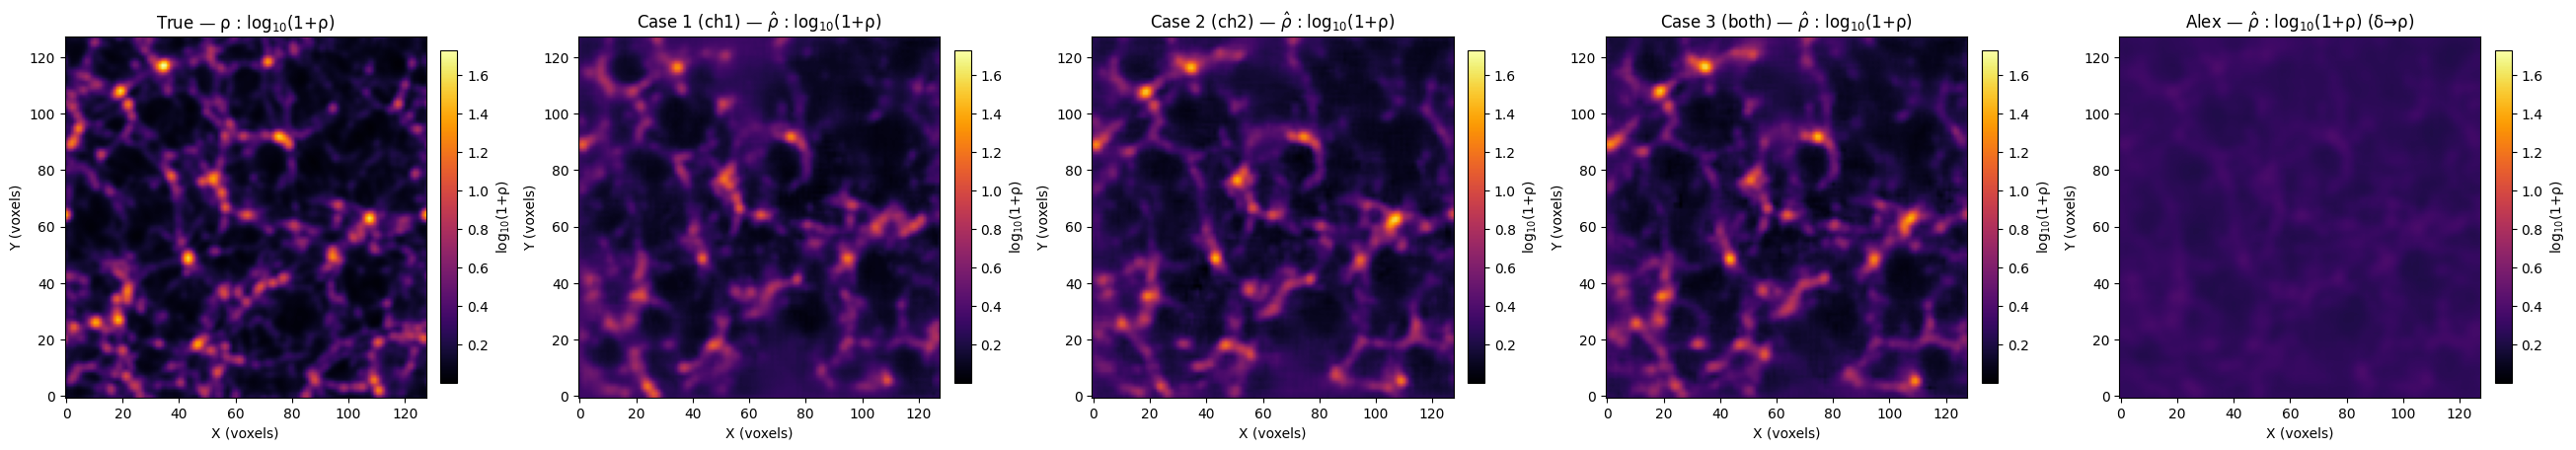

[16:21:16] INFO - [SAVED] 5-panel maps → ./figs_case_compare_index000/maps_index000_axis2.png
[16:21:16] INFO - Computing and plotting Joint PDFs...


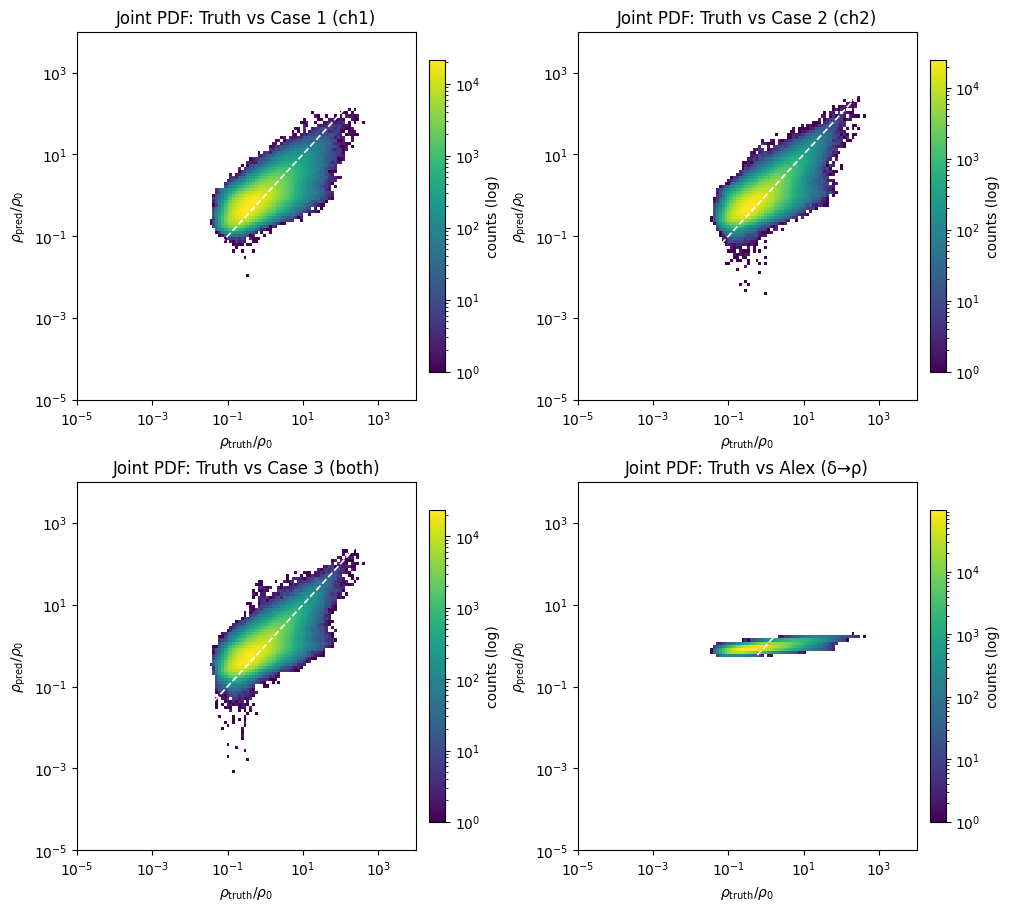

[16:21:21] INFO - [SAVED] Joint PDF → ./figs_case_compare_index000/joint_pdf_index000.png
[16:21:21] INFO - All visualizations completed successfully.
[16:21:21] INFO - Files used:
  True : /scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/0.hdf5
  Case1: /home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251021_163947/icase-ch1/0.hdf5
  Case2: /home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251022_164527/icase-ch2/0.hdf5
  Case3: /home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251014_210016/0.hdf5
  Alex : /scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/predictions/test_0_final_mode0_lr_min1e-07_max1e-05_200epochs_rho_240712_a100_cmb_f2.5.npy  (converted δ→ρ=True)


In [2]:
# -*- coding: utf-8 -*-
"""
Visualize index=0:
  (A) 5-panel maps: Truth, case1(ch1), case2(ch2), case3(both), Alex
  (B) Joint PDF(Truth vs Prediction): 4 subplots (case1, case2, case3, Alex)

All images use log10(1+ρ) with shared vmin/vmax for fair comparison.
Alex prediction is auto-converted from overdensity δ to ρ if needed.
"""

import os, glob, h5py, logging
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# ===============================
# Logger setup
# ===============================
logger = logging.getLogger("compare_cases")
if not logger.handlers:
    h = logging.StreamHandler()
    h.setFormatter(logging.Formatter("[%(asctime)s] %(levelname)s - %(message)s", "%H:%M:%S"))
    logger.addHandler(h)
logger.setLevel(logging.INFO)

# ===============================
# User settings
# ===============================
INDEX = 0
SLICE_AXIS = 2               # 0,1,2 중 선택
SLICE_INDEX_MODE = "center"  # "center" 또는 int
OUTDIR = f"./figs_case_compare_index{INDEX:03d}"
os.makedirs(OUTDIR, exist_ok=True)

# ----- data paths -----
TEST_FILE = f"/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/{INDEX}.hdf5"
CASE1_DIR = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251021_163947/icase-ch1"
CASE2_DIR = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251022_164527/icase-ch2"
CASE3_DIR = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251014_210016"
ALEX_PRED_PATTERN_TPL = "/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/predictions/test_{idx}_final_*.npy"

PDF_LOG_MIN, PDF_LOG_MAX = -5.0, 4.0
JOINT_BINS = 120

# ===============================
# Utilities
# ===============================
def _safesqueeze(a):
    a = np.squeeze(np.asarray(a))
    if a.ndim < 3:
        raise ValueError(f"Unexpected ndim {a.ndim} for shape {a.shape}")
    return a

def _get_slice(vol3d, axis=2, idx="center"):
    if idx == "center":
        idx = vol3d.shape[axis] // 2
    if axis == 0:   return vol3d[idx,:,:]
    elif axis == 1: return vol3d[:,idx,:]
    elif axis == 2: return vol3d[:,:,idx]
    else: raise ValueError("axis must be 0,1,2")

def _log10p(a):
    return np.log10(1.0 + np.clip(a, 0, None))

def _load_truth(test_path):
    logger.info(f"Loading True density: {test_path}")
    with h5py.File(test_path, "r") as f:
        return _safesqueeze(f["output_rho"][:])

def _load_pred_h5(pred_dir, idx):
    p = os.path.join(pred_dir, f"{idx}.hdf5")
    logger.info(f"Loading prediction: {p}")
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Prediction HDF5 not found: {p}")
    with h5py.File(p, "r") as f:
        return _safesqueeze(f["prediction"][:]), p

def _load_alex(idx, tpl):
    pats = sorted(glob.glob(tpl.format(idx=idx)))
    if not pats:
        raise FileNotFoundError(f"No Alex npy found: {tpl.format(idx=idx)}")
    logger.info(f"Loading Alex baseline: {pats[0]}")
    arr = _safesqueeze(np.load(pats[0]))
    if arr.min() < 0 or arr.max() < 1.0:
        arr = arr + 1.0
        logger.info("Detected overdensity (δ). Applied δ→ρ correction (+1).")
        converted = True
    else:
        converted = False
    return arr, pats[0], converted

def _joint_hist_truth_vs_pred(rho_true, rho_pred, bins=JOINT_BINS,
                              log_min=PDF_LOG_MIN, log_max=PDF_LOG_MAX):
    t, p = rho_true.ravel(), rho_pred.ravel()
    m = np.isfinite(t) & np.isfinite(p) & (t > 0) & (p > 0)
    t, p = t[m], p[m]
    edges = np.linspace(log_min, log_max, bins+1)
    H, xe, ye = np.histogram2d(np.log10(t), np.log10(p), bins=[edges, edges])
    return H, xe, ye

# ===============================
# Load data
# ===============================
logger.info(f"=== Loading datasets for index {INDEX} ===")
rho_true = _load_truth(TEST_FILE)
rho_c1, path_c1 = _load_pred_h5(CASE1_DIR, INDEX)
rho_c2, path_c2 = _load_pred_h5(CASE2_DIR, INDEX)
rho_c3, path_c3 = _load_pred_h5(CASE3_DIR, INDEX)
rho_alex, path_alex, alex_converted = _load_alex(INDEX, ALEX_PRED_PATTERN_TPL)
logger.info("All datasets successfully loaded.")

# ===============================
# (A) 5-panel visualization map
# ===============================
logger.info("Generating 5-panel visualization map...")
slice_true = _get_slice(rho_true, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
slice_c1   = _get_slice(rho_c1,   axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
slice_c2   = _get_slice(rho_c2,   axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
slice_c3   = _get_slice(rho_c3,   axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
slice_alex = _get_slice(rho_alex, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)

imgs = [_log10p(x) for x in [slice_true, slice_c1, slice_c2, slice_c3, slice_alex]]
vmin = min(img.min() for img in imgs)
vmax = max(img.max() for img in imgs)

fig, axes = plt.subplots(1, 5, figsize=(26, 5.5), constrained_layout=True)
titles = [
    "True — ρ : log$_{10}$(1+ρ)",
    "Case 1 (ch1) — $\\hat{\\rho}$ : log$_{10}$(1+ρ)",
    "Case 2 (ch2) — $\\hat{\\rho}$ : log$_{10}$(1+ρ)",
    "Case 3 (both) — $\\hat{\\rho}$ : log$_{10}$(1+ρ)",
    f"Alex — $\\hat{{\\rho}}$ : log$_{{10}}$(1+ρ){' (δ→ρ)' if alex_converted else ''}"
]
for ax, img, title in zip(axes, imgs, titles):
    im = ax.imshow(img, origin="lower", cmap="inferno", vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel("X (voxels)")
    ax.set_ylabel("Y (voxels)")
    cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label("log$_{10}$(1+ρ)")
out_map = os.path.join(OUTDIR, f"maps_index{INDEX:03d}_axis{SLICE_AXIS}.png")
plt.savefig(out_map, dpi=200)
plt.show()
plt.close(fig)
logger.info(f"[SAVED] 5-panel maps → {out_map}")

# ===============================
# (B) Joint PDF (Truth vs Prediction)
# ===============================
logger.info("Computing and plotting Joint PDFs...")
def _plot_joint(ax, H, xe, ye, title):
    x, y = 10**xe, 10**ye
    Hmask = np.ma.masked_where(H <= 0, H)
    pcm = ax.pcolormesh(x, y, Hmask.T, shading='auto', norm=LogNorm())
    cb = plt.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label("counts (log)")
    xmin, xmax = x[0], x[-1]
    ax.plot([xmin, xmax], [xmin, xmax], 'w--', lw=1.2)
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel(r"$\rho_{\rm truth}/\rho_0$")
    ax.set_ylabel(r"$\rho_{\rm pred}/\rho_0$")
    ax.set_title(title)

H1, xe, ye = _joint_hist_truth_vs_pred(rho_true, rho_c1)
H2, _, _  = _joint_hist_truth_vs_pred(rho_true, rho_c2)
H3, _, _  = _joint_hist_truth_vs_pred(rho_true, rho_c3)
HA, _, _  = _joint_hist_truth_vs_pred(rho_true, rho_alex)

fig, axs = plt.subplots(2, 2, figsize=(10, 9), constrained_layout=True)
axs = axs.ravel()
_plot_joint(axs[0], H1, xe, ye, "Joint PDF: Truth vs Case 1 (ch1)")
_plot_joint(axs[1], H2, xe, ye, "Joint PDF: Truth vs Case 2 (ch2)")
_plot_joint(axs[2], H3, xe, ye, "Joint PDF: Truth vs Case 3 (both)")
_plot_joint(axs[3], HA, xe, ye, f"Joint PDF: Truth vs Alex{' (δ→ρ)' if alex_converted else ''}")
out_joint = os.path.join(OUTDIR, f"joint_pdf_index{INDEX:03d}.png")
plt.savefig(out_joint, dpi=200)
plt.show()
plt.close(fig)
logger.info(f"[SAVED] Joint PDF → {out_joint}")

# ===============================
# Summary
# ===============================
logger.info("All visualizations completed successfully.")
logger.info(f"Files used:\n  True : {TEST_FILE}\n  Case1: {path_c1}\n  Case2: {path_c2}\n  Case3: {path_c3}\n  Alex : {path_alex}  (converted δ→ρ={alex_converted})")


In [5]:
# -*- coding: utf-8 -*-
"""
Compute mean-level quantitative metrics for case1(ch1), case2(ch2), case3(both)
on a few randomly sampled indices — fast version.
"""

import os, re, glob, h5py, logging, random
import numpy as np
from scipy.stats import pearsonr, ks_2samp

# ======== Logger ========
logger = logging.getLogger("fast_eval")
if not logger.handlers:
    h = logging.StreamHandler()
    h.setFormatter(logging.Formatter("[%(asctime)s] %(levelname)s - %(message)s", "%H:%M:%S"))
    logger.addHandler(h)
logger.setLevel(logging.INFO)

# ======== User config ========
CASE1_DIR = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251021_163947/icase-ch1"
CASE2_DIR = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251022_164527/icase-ch2"
CASE3_DIR = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251014_210016"
TEST_TPL  = "/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/{idx}.hdf5"

N_SAMPLE_INDICES = 10    # 평가에 사용할 무작위 인덱스 개수
SEED = 42

# ======== Utilities ========
def _s(a): return np.squeeze(np.asarray(a))

def _collect_indices(pred_dir):
    return sorted(int(m.group(1)) for fn in os.listdir(pred_dir)
                  if (m:=re.match(r"(\d+)\.hdf5$", fn)))

def _read_truth(idx):
    with h5py.File(TEST_TPL.format(idx=idx), "r") as f:
        return _s(f["output_rho"][:])

def _read_pred(pred_dir, idx):
    path = os.path.join(pred_dir, f"{idx}.hdf5")
    with h5py.File(path, "r") as f:
        return _s(f["prediction"][:])

def _metrics(rho_t, rho_p, ks_sample=50000):
    eps = 1e-8
    t, p = rho_t.ravel(), rho_p.ravel()
    mask = np.isfinite(t) & np.isfinite(p)
    t, p = t[mask], p[mask]

    rmse = np.sqrt(np.mean((p - t)**2))
    mae = np.mean(np.abs(p - t))
    pr = pearsonr(t, p)[0]

    lr = np.log10(np.clip(p, eps, None) / np.clip(t, eps, None))
    mu_lr, sd_lr = np.mean(lr), np.std(lr)

    tp = t[t>0]; pp = p[p>0]
    n = min(len(tp), len(pp), ks_sample)
    ks = ks_2samp(tp[:n], pp[:n]).statistic if n>100 else np.nan

    return dict(RMSE=rmse, MAE=mae, Pearson=pr,
                log_bias=mu_lr, log_std=sd_lr, KS=ks)

# ======== Sampling ========
all_indices = _collect_indices(CASE3_DIR)
random.seed(SEED)
sel_indices = random.sample(all_indices, min(N_SAMPLE_INDICES, len(all_indices)))
logger.info(f"Randomly selected indices: {sel_indices}")

# ======== Compute ========
results = {"case1": [], "case2": [], "case3": []}

for idx in sel_indices:
    rho_t = _read_truth(idx)
    rho1 = _read_pred(CASE1_DIR, idx)
    rho2 = _read_pred(CASE2_DIR, idx)
    rho3 = _read_pred(CASE3_DIR, idx)

    for label, rho in zip(["case1","case2","case3"], [rho1,rho2,rho3]):
        results[label].append(_metrics(rho_t, rho))

# ======== Aggregate ========
def avg_case(label):
    arr = results[label]
    keys = arr[0].keys()
    return {k: np.nanmean([a[k] for a in arr]) for k in keys}

summary = {lbl: avg_case(lbl) for lbl in ["case1","case2","case3"]}

print("\n=== Mean Metrics over Sampled Indices ===")
for k,v in summary.items():
    print(f"\n[{k}]")
    for metric, val in v.items():
        print(f"  {metric:10s} : {val: .4e}")


[16:26:40] INFO - Randomly selected indices: [228, 51, 563, 501, 457, 285, 209, 1116, 178, 1209]



=== Mean Metrics over Sampled Indices ===

[case1]
  RMSE       :  1.9147e+00
  MAE        :  6.3083e-01
  Pearson    :  6.2217e-01
  log_bias   :  1.2168e-01
  log_std    :  3.1913e-01
  KS         :  4.1053e-01

[case2]
  RMSE       :  1.6634e+00
  MAE        :  5.8720e-01
  Pearson    :  7.3132e-01
  log_bias   :  1.3860e-01
  log_std    :  3.0524e-01
  KS         :  4.2922e-01

[case3]
  RMSE       :  1.6510e+00
  MAE        :  5.7475e-01
  Pearson    :  7.3623e-01
  log_bias   :  1.2338e-01
  log_std    :  3.0247e-01
  KS         :  3.9456e-01
